# Demo real-time signal analysis
This demonstrates the use of low-level routines to perform signal analysis.

Each analysis product is returned as a `xarray.DataArray`. At the end, they are merged into a single `xarray.Dataset` containing all all the different data results along with their labels, coordinates, and metadata.

The input data used here is a cellular LTE capture from a benchtop base station emulator, which is available publicly from [High-SNR I/Q Recordings of FDD LTE User Equipment Emissions](https://data.nist.gov/pdr/lps/ark:/88434/mds2-3177) by Forsyth _et al_.

In [1]:
from matplotlib import pyplot as plt
import iqwaveform.figures
import numpy as np
import channel_analysis
from iqwaveform import powtodB
from channel_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

iq = np.load('cmw500-fdd-15.36MSps.npy')[np.newaxis,:]
fs = 15.36e6
duration = 0.1
iq = iq[:, : round(duration * fs)]
capture = channel_analysis.FilteredCapture(sample_rate=fs, analysis_bandwidth=10e6)

### Channel power time-series

In [2]:
pvt = channel_analysis.channel_power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    power_detectors=('rms', 'peak'),
)

In [3]:
%%timeit -n1 -r1

channel_analysis.channel_power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    power_detectors=('rms', 'peak'),
)

8.04 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


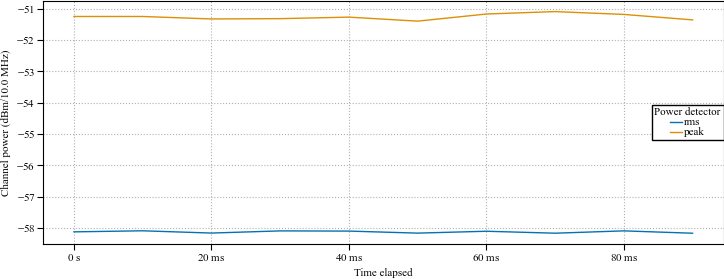

In [4]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from channel_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis('x', pvt.time_elapsed)
figures.label_axis('y', pvt, tick_units=False)
figures.label_legend(pvt.power_detector)

### Cyclic channel power

In [5]:
cyclic_power = channel_analysis.cyclic_channel_power(
    iq,
    capture,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    power_detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
)

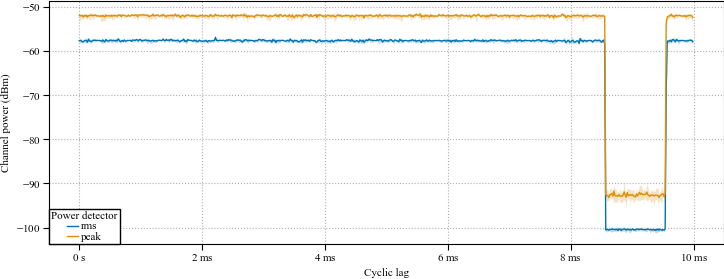

In [6]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, (a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        (a.sel(cyclic_statistic='min')),
        (a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis('x', cyclic_power.cyclic_lag)
figures.label_axis('y', cyclic_power, tick_units=False)
figures.label_legend(cyclic_power.power_detector)

### Cellular cyclic autocorrelation

In [7]:
cyclic_autocorrelation = channel_analysis.cellular_cyclic_autocorrelation(
    iq,
    capture,
    subcarrier_spacings=(15e3, 30e3, 60e3),
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


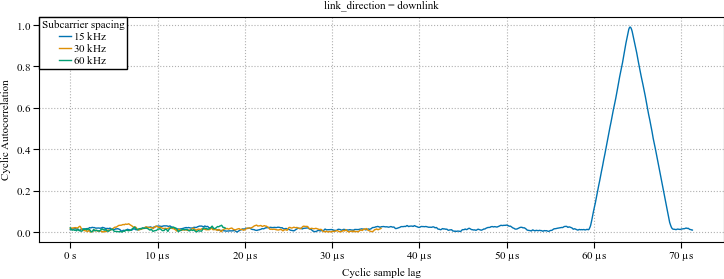

In [8]:
fig, ax = plt.subplots()

cyclic_autocorrelation.sel(link_direction='downlink').plot.line(x='cyclic_sample_lag', ax=ax)
figures.label_axis('x', cyclic_autocorrelation.cyclic_sample_lag)
figures.label_legend(cyclic_autocorrelation.subcarrier_spacing)

### Persistence Spectrum

In [9]:
frequency_resolution = 30e3
frequency_stats = [0.5, 0.75, 0.95, 0.99, 'max']

spectrum = channel_analysis.power_spectral_density(
    iq,
    capture,
    window=('dpss', 3.87638403),
    frequency_resolution=frequency_resolution,
    frequency_statistic=frequency_stats,
)

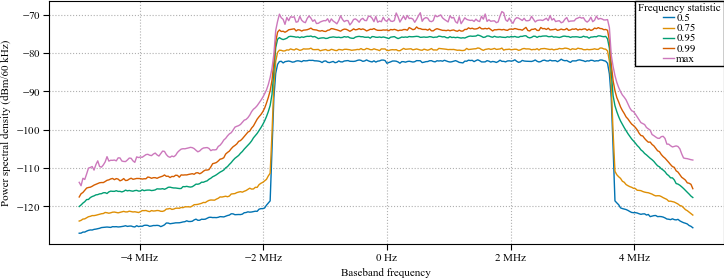

In [10]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis('x', spectrum.baseband_frequency)
figures.label_axis('y', spectrum, tick_units=False)
# figures.label_legend(ax, spectrum, 'persistence_statistic')

### Spectrogram

In [11]:
spectrogram = channel_analysis.spectrogram(
    iq,
    capture,
    window=('dpss', 3.87638403),
    frequency_resolution=15e3,
    fractional_overlap=0.0,
    frequency_bin_averaging=12,
    time_bin_averaging=None,
)

In [ ]:
spectrogram.sel(spectrogram_time=slice(0,40e-3)).T.plot()
figures.label_axis('y', spectrogram.spectrogram_baseband_frequency, tick_units=False)
figures.label_axis('x', spectrogram.spectrogram_time)
figures.label_axis('colorbar', spectrogram, tick_units=False)
fig = plt.gcf()

### Spectrogram Power Histogram

In [ ]:
resource_power_histogram = channel_analysis.spectrogram_histogram(
    iq,
    capture,
    window=('dpss', 3.87638403),
    power_low=-170,
    power_high=0,
    power_resolution=0.25,
    frequency_resolution=15e3,
    fractional_overlap=0.0,
    frequency_bin_averaging=12,
    time_bin_averaging=15
)

In [ ]:
fig, ax = plt.subplots()

resource_power_histogram.sel(spectrogram_power_bin=slice(-135,-75)).plot(x='spectrogram_power_bin', ax=ax)
figures.label_axis('x', resource_power_histogram.spectrogram_power_bin, tick_units=False)

### Putting it all together

In [ ]:
# %%timeit -n1 -r1

# del iq

# iq = channel_analysis.simulated_awgn(capture, xp=np)
# iq = channel_analysis.filter_iq_capture(iq, capture)

analysis_spec = {
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'power_detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'power_spectral_density': {
        # 'window': 'flattop',
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
        'frequency_resolution': 1e3,
        'frequency_statistic': [0.5, 0.75, 0.95, 0.99, 1],
        'trim_stopband': False,
    },
    'spectrogram': {
        'window': ('dpss', 3.87638403),
        'frequency_resolution': 15e3,
        'fractional_overlap': 0.0,
        'frequency_bin_averaging': 12,
        'time_bin_averaging': None,
    },
    'cellular_cyclic_autocorrelation': {'subcarrier_spacings': [15e3, 30e3, 60e3]},
}

filter_spec = {
    'nfft': 1024,
    'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
}

result = channel_analysis.analyze_by_spec(iq, capture, spec=analysis_spec)
result

In [ ]:
%%timeit -n1 -r1

channel_analysis.analyze_by_spec(
    iq,
    capture,
    spec=analysis_spec,
)

In [ ]:
# %timeit -n1 -r1 channel_analysis.dump('test.zarr.zip', result, mode='w')